In [88]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import clusterbycolumn as cbc
import requests
import asinfo

import matplotlib.dates as dates
from datetime import datetime as dt

In [89]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [90]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [91]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [92]:
dailydb_location = './youtube.db'

In [93]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , video_download_bytes_sec
                  , audio_download_bytes_sec
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           and successes = 1
           and failures = 0;
        '''

In [94]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [95]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
dtype: int64

In [96]:
df.head()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec
0,samsbox81,2016-09-05 16:29:41,193.212.4.15,2006335,1242187
1,samsbox81,2016-09-05 16:30:23,2001:4600:9:307::f,2032809,1146949
2,samsbox81,2016-09-05 17:26:17,193.212.4.15,1946785,1214358
3,samsbox81,2016-09-05 17:26:59,2001:4600:9:307::f,2008980,889966
4,samsbox81,2016-09-05 18:25:53,193.212.4.15,1927047,1181569


In [97]:
df["video_mbits"] = df["video_download_bytes_sec"].div(1024).div(1024).mul(8)

In [98]:
overall_median = df["video_download_bytes_sec"].median()
overall_mean = df["video_download_bytes_sec"].mean()
print("Median: " + str(overall_median) + " (" + str(round(df["video_mbits"].median(), 2)) + " Mbit/s)")
print ("and mean: " + str(round(overall_mean)) + " (" + str(round(df["video_mbits"].mean(),2)) +" Mbit/s)")

Median: 1385397.0 (10.57 Mbit/s)
and mean: 1817643.0 (13.87 Mbit/s)


In [99]:
df["video_mbits"].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).apply(lambda x: format(x, 'f'))

count    4422465.000000
mean          13.867518
std           11.915485
min            0.000000
5%             3.124481
10%            4.393944
25%            6.646240
50%           10.569740
75%           16.654869
90%           27.162007
95%           28.380641
max          176.279022
Name: video_mbits, dtype: object

In [100]:
df["probe"].describe()

count       4422465
unique          102
top       samsbox03
freq          74284
Name: probe, dtype: object

In [105]:
dates_with_max_greater_50 = df[df['video_mbits'] > 50]
#dates_with_max_greater_50['probe'].unique()
dates_with_max_greater_50.count()

probe                       91687
dtime                       91687
video_address               91687
video_download_bytes_sec    91687
audio_download_bytes_sec    91687
video_mbits                 91687
dtype: int64

In [116]:
#df_time_period = df[df['dtime'] > "2014-12-10" and df['dtime'] < "2015-06-26"]
df_time_period = df[(df['dtime'] > "2014-12-10")]
df_time_period = df_time_period[df_time_period['dtime'] < "2015-06-28"]
df_time_period.head()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec,video_mbits
12242,samsbox02,2014-12-10 06:27:09,2a00:1450:4005:6::12,809187,61452,6.173607
12243,samsbox02,2014-12-10 07:26:21,2a00:1450:4005:6::12,810795,61615,6.185875
12244,samsbox02,2014-12-10 08:27:10,64.15.112.79,804519,62068,6.137993
12245,samsbox02,2014-12-10 09:26:25,64.15.112.79,795560,62254,6.069641
12246,samsbox02,2014-12-10 12:30:44,64.15.112.79,4159337,1974874,31.733223


In [117]:
df_time_period.tail()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec,video_mbits
4309897,samsbox11,2015-06-27 20:28:18,2a00:1450:400e:18::14,1522592,15145,11.616455
4309898,samsbox11,2015-06-27 21:27:12,83.255.235.17,2474828,2593647,18.881439
4309899,samsbox11,2015-06-27 21:28:25,2a00:1450:400e:18::14,622718,818561,4.750961
4309900,samsbox11,2015-06-27 22:26:50,83.255.235.17,2017811,2343421,15.394676
4309901,samsbox11,2015-06-27 22:27:59,2a00:1450:400e:18::14,1194019,1676055,9.109642


In [15]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [16]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [17]:
df.head()

,probe,dtime,video_address,video_download_bytes_sec,audio_download_bytes_sec,video_mbits
0,samsbox81,2016-09-05 16:00:00,193.212.4.15,2006335,1242187,15.307121
1,samsbox81,2016-09-05 16:00:00,2001:4600:9:307::f,2032809,1146949,15.509102
2,samsbox81,2016-09-05 17:00:00,193.212.4.15,1946785,1214358,14.852791
3,samsbox81,2016-09-05 17:00:00,2001:4600:9:307::f,2008980,889966,15.327301
4,samsbox81,2016-09-05 18:00:00,193.212.4.15,1927047,1181569,14.702202


In [18]:
time_begin = df["dtime"].min()
time_end = df["dtime"].max()
print("Data set from " + str(time_begin) + " until " + str(time_end))

Data set from 2014-08-20 01:00:00 until 2017-06-27 23:00:00


In [19]:
num_probes = len(set(df['probe']))

In [20]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
video_mbits                 4422465
dtype: int64

In [21]:
df = df.dropna()

In [22]:
df.count()

probe                       4422465
dtime                       4422465
video_address               4422465
video_download_bytes_sec    4422465
audio_download_bytes_sec    4422465
video_mbits                 4422465
dtype: int64

In [23]:
df['v_MB_sec'] = df['video_download_bytes_sec'].div(1024).div(1024)
df['a_MB_sec'] = df['audio_download_bytes_sec'].div(1024).div(1024)

del df['video_download_bytes_sec']
del df['audio_download_bytes_sec']

In [24]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [25]:
dfv4, dfv6 = filter_by_ip(df, column = 'video_address')

In [26]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [27]:
dfv4.head()

,dtime,video_address,video_mbits,v_MB_sec,a_MB_sec,name
0,2016-09-05 16:00:00,193.212.4.15,15.307121,1.913390,1.184642,#81
2,2016-09-05 17:00:00,193.212.4.15,14.852791,1.856599,1.158102,#81
4,2016-09-05 18:00:00,193.212.4.15,14.702202,1.837775,1.126832,#81
6,2016-09-05 19:00:00,193.212.4.15,15.251617,1.906452,1.091392,#81
8,2016-09-05 20:00:00,193.212.4.15,15.171806,1.896476,0.974868,#81


In [28]:
dfv6.head()

,dtime,video_address,video_mbits,v_MB_sec,a_MB_sec,name
1,2016-09-05 16:00:00,2001:4600:9:307::f,15.509102,1.938638,1.093816,#81
3,2016-09-05 17:00:00,2001:4600:9:307::f,15.327301,1.915913,0.848738,#81
5,2016-09-05 18:00:00,2001:4600:9:307::f,14.570908,1.821363,1.107177,#81
7,2016-09-05 19:00:00,2001:4600:9:307::f,14.677574,1.834697,1.188632,#81
9,2016-09-05 20:00:00,2001:4600:9:307::f,15.274780,1.909348,0.801767,#81


In [29]:
dfv4['dtime'].nunique()

24637

In [30]:
dfv4.count()

dtime            2379444
video_address    2379444
video_mbits      2379444
v_MB_sec         2379444
a_MB_sec         2379444
name             2379444
dtype: int64

In [31]:
unique_v4_values = dfv4.groupby('dtime')['video_mbits'].nunique()

In [32]:
unique_v4_values.describe()

count    24637.000000
mean        51.829444
std         21.256738
min          1.000000
25%         37.000000
50%         59.000000
75%         65.000000
max         87.000000
Name: video_mbits, dtype: float64

In [33]:
unique_v4_greater10 = unique_v4_values[unique_v4_values > 10]

In [34]:
unique_v4_greater10.head()

dtime
2014-08-26 15:00:00    16
2014-08-26 16:00:00    16
2014-08-26 17:00:00    16
2014-08-26 18:00:00    16
2014-08-26 19:00:00    17
Name: video_mbits, dtype: int64

In [35]:
dfv4_min = dfv4.groupby('dtime').min()
dfv4_max = dfv4.groupby('dtime').max()
#qv6 = dfv6.groupby('dtime').quantile([0.05, 0.1, 0,25, 0.5, 0.75, 0.9, 0.95])
dfv6_min = dfv6.groupby('dtime').min()
dfv6_max = dfv6.groupby('dtime').max()

del dfv4_min['video_address']; del dfv6_min['video_address']; del dfv4_min['name']; del dfv6_min['name']

del dfv4_max['video_address']; del dfv6_max['video_address']; del dfv4_max['name']; del dfv6_max['name']

In [36]:
dfv4_min.head()

,video_mbits,v_MB_sec,a_MB_sec
dtime,,,
2014-08-20 01:00:00,3.490326,0.436291,0.077405
2014-08-20 04:00:00,3.485725,0.435716,0.079950
2014-08-20 06:00:00,3.471138,0.433892,0.079645
2014-08-20 08:00:00,3.484932,0.435616,0.079309
2014-08-20 09:00:00,3.505684,0.438210,0.080091


In [37]:
dfv4_median = dfv4.groupby('dtime').median()
dfv6_median = dfv6.groupby('dtime').median()
dfv4_q5 = dfv4.groupby('dtime').quantile(0.05)
dfv6_q5 = dfv6.groupby('dtime').quantile(0.05)
dfv4_q10 = dfv4.groupby('dtime').quantile(0.1)
dfv6_q10 = dfv6.groupby('dtime').quantile(0.1)
dfv4_q25 = dfv4.groupby('dtime').quantile(0.25)
dfv6_q25 = dfv6.groupby('dtime').quantile(0.25)
dfv4_q75 = dfv4.groupby('dtime').quantile(0.75)
dfv6_q75 = dfv6.groupby('dtime').quantile(0.75)
dfv4_q90 = dfv4.groupby('dtime').quantile(0.90)
dfv6_q90 = dfv6.groupby('dtime').quantile(0.90)
dfv4_q95 = dfv4.groupby('dtime').quantile(0.95)
dfv6_q95 = dfv6.groupby('dtime').quantile(0.95)

In [38]:
dfv4_agg = pd.DataFrame(data = {"q00": dfv4_min["video_mbits"],
                               "q_max": dfv4_max["video_mbits"],
                        "q05": dfv4_q5["video_mbits"],
                        "q10": dfv4_q10["video_mbits"],
                        "q25": dfv4_q25["video_mbits"],
                        "q50": dfv4_median["video_mbits"],
                        "q75": dfv4_q75["video_mbits"],
                        "q90": dfv4_q90["video_mbits"],
                        "q95": dfv4_q95["video_mbits"]})

dfv6_agg = pd.DataFrame(data = {"q00": dfv6_min["video_mbits"],
                               "q_max": dfv6_max["video_mbits"],
                        "q05": dfv6_q5["video_mbits"],
                        "q10": dfv6_q10["video_mbits"],
                        "q25": dfv6_q25["video_mbits"],
                        "q50": dfv6_median["video_mbits"],
                        "q75": dfv6_q75["video_mbits"],
                        "q90": dfv6_q90["video_mbits"],
                        "q95": dfv6_q95["video_mbits"]})

In [39]:
dfv4_agg.tail()

,q00,q05,q10,q25,q50,q75,q90,q95,q_max
dtime,,,,,,,,,
2017-06-27 19:00:00,2.199905,4.610089,5.370958,6.093216,6.371414,7.345749,7.687672,7.764685,7.961678
2017-06-27 20:00:00,2.839798,4.988984,5.782001,6.129763,6.943104,7.309141,7.710672,7.904503,7.976303
2017-06-27 21:00:00,2.368538,4.717852,5.576828,6.123501,6.860809,7.302942,7.729626,7.812328,8.049530
2017-06-27 22:00:00,2.566521,3.936543,5.381943,6.131844,6.498375,7.326065,7.716843,7.806919,7.973503
2017-06-27 23:00:00,3.509148,5.512974,5.947418,6.112835,7.001945,7.468578,7.778685,7.850784,10.627434


In [40]:
dfv6_agg.tail()

,q00,q05,q10,q25,q50,q75,q90,q95,q_max
dtime,,,,,,,,,
2017-06-27 19:00:00,3.024315,4.775301,5.730832,6.079414,6.916779,7.298847,7.742220,7.878570,8.144135
2017-06-27 20:00:00,2.051147,5.050357,5.689194,6.069740,6.967850,7.309910,7.711441,7.887523,8.065536
2017-06-27 21:00:00,2.093384,3.931990,5.611272,6.070543,6.898853,7.290825,7.771281,7.880476,8.021378
2017-06-27 22:00:00,2.787888,4.018410,5.328316,6.064194,6.710236,7.311813,7.825752,7.868347,7.999786
2017-06-27 23:00:00,4.174294,5.025371,5.777600,6.083076,7.077744,7.350975,7.776492,7.874297,7.988586


In [41]:
df = pd.merge(dfv4_agg, dfv6_agg, on=["dtime"])

In [42]:
df.count()

q00_x      24602
q05_x      24602
q10_x      24602
q25_x      24602
q50_x      24602
q75_x      24602
q90_x      24602
q95_x      24602
q_max_x    24602
q00_y      24602
q05_y      24602
q10_y      24602
q25_y      24602
q50_y      24602
q75_y      24602
q90_y      24602
q95_y      24602
q_max_y    24602
dtype: int64

In [43]:
df.index.name = 'dtime'
df.reset_index(inplace=True)

In [44]:
df.tail()
# x is IPv4, y is IPv6

,dtime,q00_x,q05_x,q10_x,q25_x,q50_x,q75_x,q90_x,q95_x,q_max_x,q00_y,q05_y,q10_y,q25_y,q50_y,q75_y,q90_y,q95_y,q_max_y
24597,2017-06-27 19:00:00,2.199905,4.610089,5.370958,6.093216,6.371414,7.345749,7.687672,7.764685,7.961678,3.024315,4.775301,5.730832,6.079414,6.916779,7.298847,7.742220,7.878570,8.144135
24598,2017-06-27 20:00:00,2.839798,4.988984,5.782001,6.129763,6.943104,7.309141,7.710672,7.904503,7.976303,2.051147,5.050357,5.689194,6.069740,6.967850,7.309910,7.711441,7.887523,8.065536
24599,2017-06-27 21:00:00,2.368538,4.717852,5.576828,6.123501,6.860809,7.302942,7.729626,7.812328,8.049530,2.093384,3.931990,5.611272,6.070543,6.898853,7.290825,7.771281,7.880476,8.021378
24600,2017-06-27 22:00:00,2.566521,3.936543,5.381943,6.131844,6.498375,7.326065,7.716843,7.806919,7.973503,2.787888,4.018410,5.328316,6.064194,6.710236,7.311813,7.825752,7.868347,7.999786
24601,2017-06-27 23:00:00,3.509148,5.512974,5.947418,6.112835,7.001945,7.468578,7.778685,7.850784,10.627434,4.174294,5.025371,5.777600,6.083076,7.077744,7.350975,7.776492,7.874297,7.988586


In [45]:
df['date'] = df['dtime'].apply(lambda d: dt.strptime(d, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d'))

In [46]:
df.sort_values(by = 'dtime', inplace = True)

### Hardcoded dates

In [47]:
from dateutil import rrule
a=dt.strptime(str('2014-08-01'), '%Y-%m-%d')
b=dt.strptime(str('2017-07-01'), '%Y-%m-%d')
dateranges = rrule.rrule(rrule.DAILY, dtstart=a).between(a, b, inc=True)

In [48]:
df_ = pd.DataFrame(dateranges, columns=['dtime']).sort_values(by = 'dtime').reset_index(drop = True)
#df = pd.merge(df_, df, how='outer')

In [49]:
df.tail(1)

,dtime,q00_x,q05_x,q10_x,q25_x,q50_x,q75_x,q90_x,q95_x,q_max_x,q00_y,q05_y,q10_y,q25_y,q50_y,q75_y,q90_y,q95_y,q_max_y,date
24601,2017-06-27 23:00:00,3.509148,5.512974,5.947418,6.112835,7.001945,7.468578,7.778685,7.850784,10.627434,4.174294,5.025371,5.7776,6.083076,7.077744,7.350975,7.776492,7.874297,7.988586,2017-06-27


In [87]:
dates_with_max_greater_50 = df[df['q_max_x'] > 50]
dates_with_max_greater_50['dtime']

2606    2014-12-10 13:00:00
2607    2014-12-10 14:00:00
2608    2014-12-10 15:00:00
2609    2014-12-10 16:00:00
2610    2014-12-10 17:00:00
2611    2014-12-10 18:00:00
2612    2014-12-10 19:00:00
2613    2014-12-10 20:00:00
2614    2014-12-10 21:00:00
2615    2014-12-10 22:00:00
2616    2014-12-10 23:00:00
2617    2014-12-11 00:00:00
2618    2014-12-11 01:00:00
2619    2014-12-11 02:00:00
2620    2014-12-11 03:00:00
2621    2014-12-11 04:00:00
2622    2014-12-11 05:00:00
2623    2014-12-11 06:00:00
2624    2014-12-11 07:00:00
2625    2014-12-11 08:00:00
2626    2014-12-11 09:00:00
2627    2014-12-11 10:00:00
2628    2014-12-11 11:00:00
2629    2014-12-11 12:00:00
2630    2014-12-11 13:00:00
2631    2014-12-11 14:00:00
2632    2014-12-11 15:00:00
2633    2014-12-11 16:00:00
2634    2014-12-11 17:00:00
2635    2014-12-11 18:00:00
               ...         
7024    2015-06-18 11:00:00
7026    2015-06-18 13:00:00
7030    2015-06-18 17:00:00
7038    2015-06-19 01:00:00
7039    2015-06-19 0

In [80]:
from matplotlib import cm
viridis_cmap = plt.cm.get_cmap('plasma')

norm = matplotlib.colors.Normalize(vmin=0, vmax=9)

cols=[]

for i in range(0, 9):
    k = matplotlib.colors.colorConverter.to_rgb(viridis_cmap(norm(i)))
    cols.append(k)


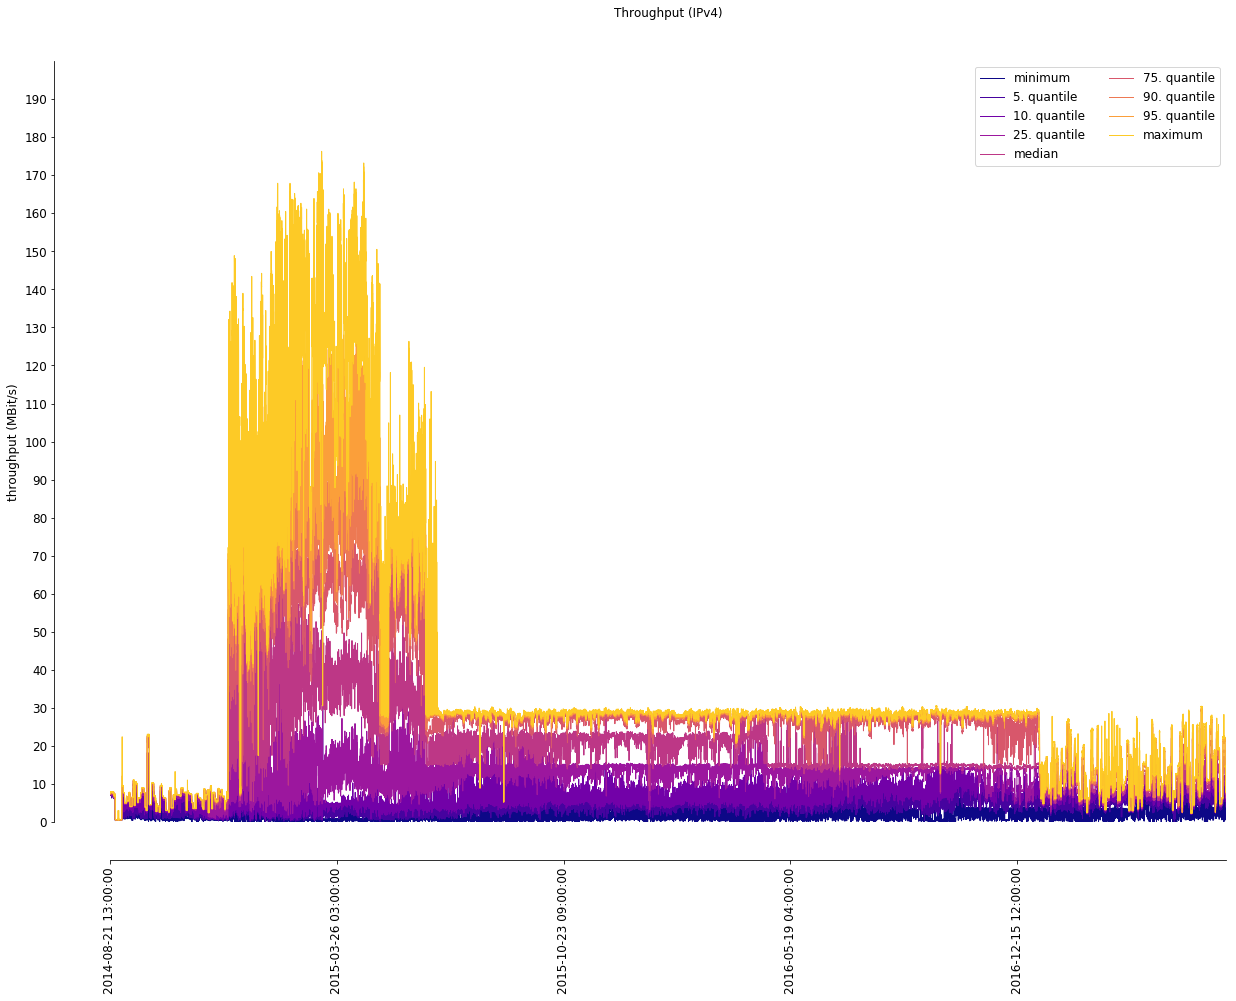

In [78]:
fig = plt.figure(figsize = (20, 14))
plt.rcParams['font.size'] = 12
ax = plt.gca()

sl = df.plot(  x='dtime'
             , y=['q00_x', 'q05_x', 'q10_x', 'q25_x', 'q50_x', 'q75_x', 'q90_x', 'q95_x', 'q_max_x']
             , color=cols
             , kind='line'
             , linewidth = 1
             , ax = ax
            )


ax.grid(False)
ax.set_xlabel('', fontsize=22)
ax.set_ylabel('throughput (MBit/s)', fontsize=12)
ax.legend(['minimum', '5. quantile', '10. quantile', '25. quantile', 'median', '75. quantile', '90. quantile', '95. quantile', 'maximum'], fontsize=12, loc='best', ncol = 2)
ax.set_yscale('linear')
ax.set_ylim([0, 200])

yticks = np.arange(0,200,10)
ax.set_yticks(yticks)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

plt.xticks(rotation=90)

#from datetime import datetime as dt
#ax.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')
#ax.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')
#ax.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')
#ax.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')

plt.title('Throughput (IPv4)', fontsize=12, y=1.05)
plt.savefig('youtube-video-throughput-timeseries_ipv4.pdf', format='pdf', bbox_inches='tight')

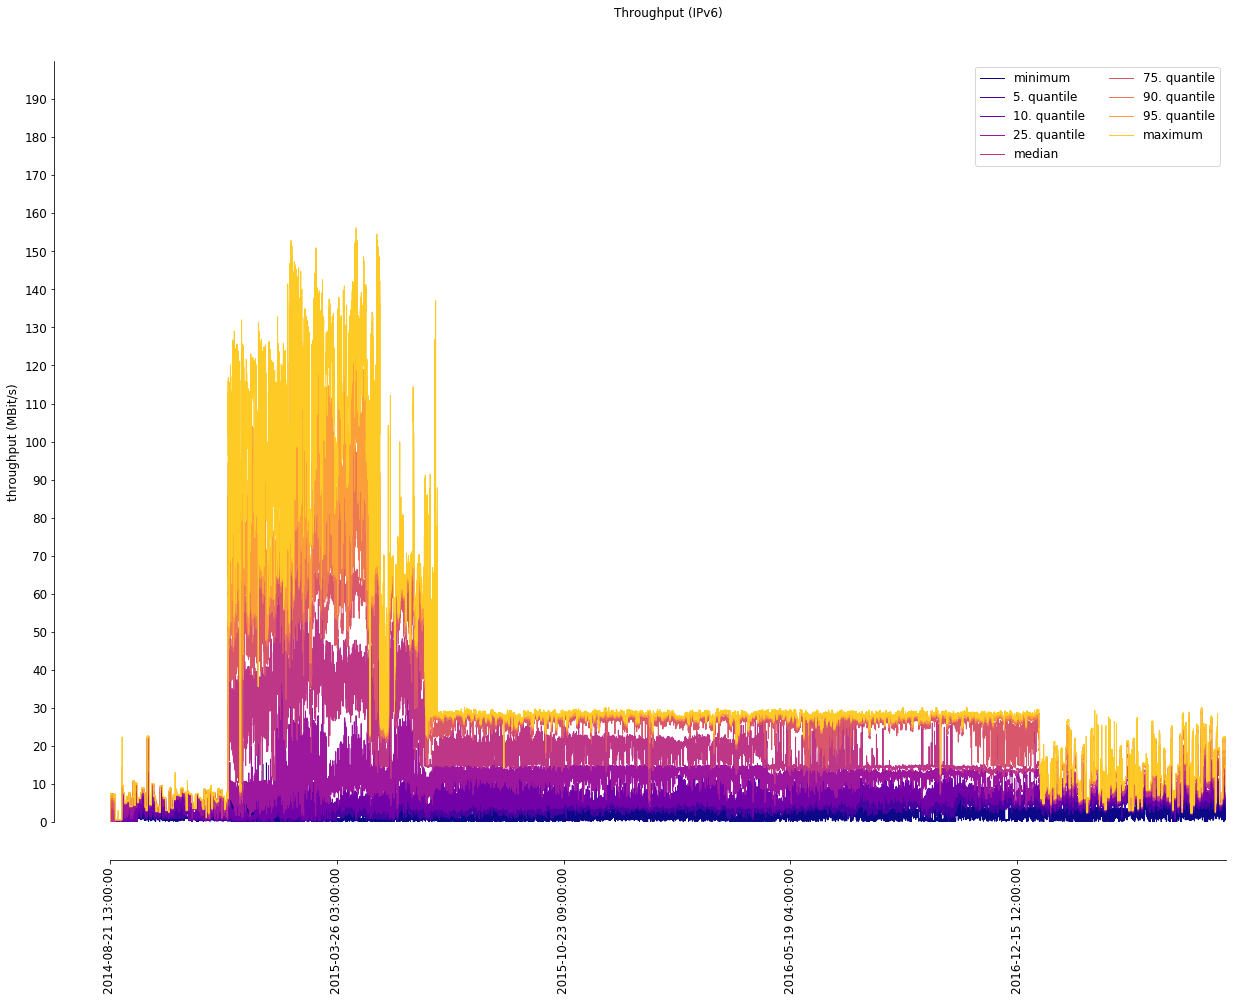

In [79]:
fig = plt.figure(figsize = (20, 14))
plt.rcParams['font.size'] = 12
ax = plt.gca()

sl = df.plot(  x='dtime'
             , y=['q00_x', 'q05_y', 'q10_y', 'q25_y', 'q50_y', 'q75_y', 'q90_y', 'q95_y', 'q_max_y']
             , color=cols
             , kind='line'
             , linewidth = 1
             , ax = ax
            )


ax.grid(False)
ax.set_xlabel('', fontsize=22)
ax.set_ylabel('throughput (MBit/s)', fontsize=12)
ax.legend(['minimum', '5. quantile', '10. quantile', '25. quantile', 'median', '75. quantile', '90. quantile', '95. quantile', 'maximum'], fontsize=12, loc='best', ncol = 2)
ax.set_yscale('linear')
ax.set_ylim([0, 200])

yticks = np.arange(0,200,10)
ax.set_yticks(yticks)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

plt.xticks(rotation=90)

#from datetime import datetime as dt
#ax.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')
#ax.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')
#ax.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')
#ax.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 200, ymin = 0, color='black', ls = 'dotted')

plt.title('Throughput (IPv6)', fontsize=12, y=1.05)
plt.savefig('youtube-video-throughput-timeseries_ipv6.pdf', format='pdf', bbox_inches='tight')